## Movie Reviews

This demonstrates a model that uses a transformer to embed the text of a movie reviews, uses additional emeddings for categorical features, and finally concats the result with other features through and MLP. The target whether the rating is good or not. The transformer is pretrained on a large corpus of text and then fine-tuned on the movie reviews dataset. A generic form of the architecture is shown below:

![](../../../img/torch_frame_architecture.png){width=25%}

## Imports

In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor

import torch_frame
from torch_frame import stype
from torch_frame.nn.encoder import (
    EmbeddingEncoder,
    LinearEmbeddingEncoder,
    LinearEncoder,
)

from torch_frame.data import Dataset
from torch_frame.data import DataLoader
from torch_frame import torch_frame


from typing import Any, Dict, List
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## Data Setup

In [3]:
df_reviews = pd.read_csv('../../../data/movie_reviews.csv')
df_reviews.shape
df_reviews.head()

,title,review_year,age,children_in_home,education,gender,work_status,genre,release_year,length_minutes,...,rating,review_text,word_count,review_year_0,release_year_0,age_sc,length_minutes_sc,total_reviews_sc,word_count_sc,rating_good
0,Visions of Valor,2019,27,2,Post-Graduate,female,Employed,Action/Adventure,1987,120,...,2.7,"I wanted to like this movie, but it was a letd...",21,19,4,-1.090556,-0.086929,-0.827284,2.107438,0
1,Hilarity Unleashed,2014,43,1,Completed College,female,Employed,Comedy,2019,121,...,4.2,Pure cinematic joy that brought tears to my eyes.,9,14,36,-0.214827,-0.000174,0.940224,-0.259140,1
2,Soulbound,2019,65,0,Post-Graduate,male,Employed,Drama,2010,131,...,3.7,An emotional rollercoaster that left me in awe...,32,19,27,0.989300,0.867377,-1.164154,4.276801,1
3,Amour Forever,2011,43,1,Post-Graduate,female,Employed,Romance,2004,134,...,2.7,A movie that failed to live up to its potentia...,11,11,21,-0.214827,1.127643,0.468395,0.135289,0
4,In Search of Truth,2003,54,1,Completed College,female,Employed,Other,2007,112,...,2.4,A movie that left me uninterested and thorough...,9,3,24,0.387236,-0.780969,0.394044,-0.259140,0


In [4]:
df_reviews.dtypes

title                 object
review_year            int64
age                    int64
children_in_home       int64
education             object
gender                object
work_status           object
genre                 object
release_year           int64
length_minutes         int64
season                object
total_reviews          int64
rating               float64
review_text           object
word_count             int64
review_year_0          int64
release_year_0         int64
age_sc               float64
length_minutes_sc    float64
total_reviews_sc     float64
word_count_sc        float64
rating_good            int64
dtype: object

In [5]:
df_reviews_model = df_reviews[[
    'review_year_0',
    'age_sc',
    'children_in_home',
    'education',
    'gender',
    'work_status',
    'genre',
    'release_year_0',
    'length_minutes_sc',
    'season',
    'total_reviews_sc',
    'review_text',   
    'rating_good'        
]]

In [6]:
from sentence_transformers import SentenceTransformer

class TextToEmbedding:
    def __init__(self, device: torch.device):
        self.model = SentenceTransformer('all-distilroberta-v1', device=device)

    def __call__(self, sentences: List[str]) -> Tensor:
        # Encode a list of batch_size sentences into a PyTorch Tensor of
        # size [batch_size, emb_dim]
        embeddings = self.model.encode(
            sentences,
            convert_to_numpy=False,
            convert_to_tensor=True,
        )
        return embeddings.cpu()

/Users/micl/anaconda3/envs/pytorch-tabular/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch_frame.config.text_embedder import TextEmbedderConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

col_to_text_embedder_cfg = TextEmbedderConfig(
    text_embedder=TextToEmbedding(device),
    batch_size=8,
)

In [8]:
# Specify the stype of each column with a dictionary.
col_to_stype = {}

for column in df_reviews_model.columns:
    if df_reviews_model[column].dtype == 'object':
        col_to_stype[column] = torch_frame.categorical
    else:
        col_to_stype[column] = torch_frame.numerical
    if column == 'review_text':
        col_to_stype[column] = torch_frame.text_embedded

pd.DataFrame(col_to_stype, index=[0])

,review_year_0,age_sc,children_in_home,education,gender,work_status,genre,release_year_0,length_minutes_sc,season,total_reviews_sc,review_text,rating_good
0,numerical,numerical,numerical,categorical,categorical,categorical,categorical,numerical,numerical,categorical,numerical,text_embedded,numerical


In [9]:
# Set "y" as the target column.
dataset = Dataset(
    df_reviews_model, 
    col_to_stype=col_to_stype, 
    col_to_text_embedder_cfg=col_to_text_embedder_cfg,
    target_col="rating_good"
)
dataset.materialize() # call after Dataset is used

dataset.shuffle()
train_dataset, test_dataset = dataset[:0.75], dataset[0.75:]

train_loader = DataLoader(train_dataset.tensor_frame, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset.tensor_frame, batch_size=64)

Embedding raw data in mini-batch: 100%|██████████| 125/125 [00:06<00:00, 20.44it/s]


## Model Setup

In [10]:
encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: LinearEncoder(),
    stype.embedding: LinearEmbeddingEncoder()
}

In [11]:
from torch_frame.nn import FTTransformer, Trompt

model = FTTransformer(
    channels=8,
    out_channels=2,
    num_layers=4,
    # num_prompts = 2,
    stype_encoder_dict= encoder_dict,
    col_stats=train_dataset.col_stats,
    col_names_dict=train_dataset.tensor_frame.col_names_dict,
).to(device)

optimizer = torch.optim.NAdam(model.parameters())


## Model Training and Evaluation

In [12]:
losses = []

for epoch in range(100):
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)
    for tf in progress_bar:
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({'Loss': loss.item()})
    
    losses.append(loss.item())

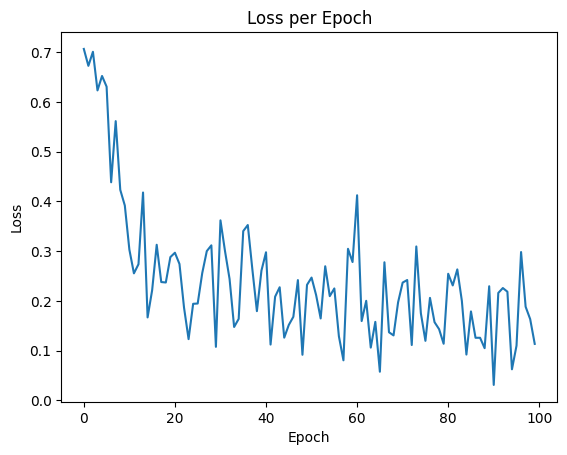

In [13]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

In [14]:
correct = 0
for tf in test_loader:
    tf = tf.to(device)
    pred = model(tf)
    pred_class = pred.argmax(dim=-1)
    correct += (tf.y == pred_class).sum()

acc = int(correct) / len(test_dataset)

print(f'Accuracy: {acc:.4f}; Guessing: {(test_dataset.df['rating_good']==1).mean():.4f}')

Accuracy: 0.8680; Guessing: 0.5560
